**Data Preparation and Feature Engineering**

In this project, we are tasked with predicting the Severity Impairment Index (SII) using internet usage and physical activity data from the Healthy Brain Network (HBN) dataset. Our journey begins by loading the dataset and preparing it for training. The train.csv and test.csv files contain the main tabular data, which we’ll combine with the time-series data stored in parquet files.

In [15]:
import pandas as pd
import glob
from fastai.tabular.all import *

# Load the train and test tabular data
path = Path('/kaggle/input/child-mind-institute-problematic-internet-use')
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

# Drop rows where 'sii' is NaN
train_df = train_df.dropna(subset=['sii'])

# Convert 'sii' to integer
train_df['sii'] = train_df['sii'].astype(int)

**Feature Extraction from Time-Series Data**

Next, we process the time-series data to extract useful features. Since the accelerometer data (X, Y, Z axes, and other metrics) is stored in parquet format, we extract statistical features such as mean and standard deviation for each axis. These features will then be merged with our main tabular data.

In [16]:
# Function to extract basic statistics (mean, std, etc.) from time-series data
def extract_time_series_features(file_path):
    df = pd.read_parquet(file_path)
    features = {
        'mean_x': df['X'].mean(),
        'std_x': df['X'].std(),
        'mean_y': df['Y'].mean(),
        'std_y': df['Y'].std(),
        'mean_z': df['Z'].mean(),
        'std_z': df['Z'].std(),
        'mean_enmo': df['enmo'].mean(),
        'std_enmo': df['enmo'].std(),
        'mean_anglez': df['anglez'].mean(),
        'std_anglez': df['anglez'].std(),
    }
    return features

# Extract features for train series data
train_series_files = glob.glob('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=*/part-*.parquet')
train_features = []
for file in train_series_files:
    features = extract_time_series_features(file)
    
    # Extract 'id' from the file path
    features['id'] = file.split('id=')[-1].split('/')[0]  # Extract id from directory structure
    train_features.append(features)

train_series_df = pd.DataFrame(train_features)

# Extract features for test series data
test_series_files = glob.glob('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=*/part-*.parquet')
test_features = []
for file in test_series_files:
    features = extract_time_series_features(file)
    
    # Extract 'id' from the file path
    features['id'] = file.split('id=')[-1].split('/')[0]  # Extract id from directory structure
    test_features.append(features)

test_series_df = pd.DataFrame(test_features)

**Merging Time-Series Features with Tabular Data**

Now that we have extracted features from the time-series data, we need to merge these features with the main tabular dataset using the id column.

In [17]:
# Merge time-series features with the original tabular data
train_combined = pd.merge(train_df, train_series_df, on='id', how='left')

# Merge time-series features with the original tabular data
test_combined = pd.merge(test_df, test_series_df, on='id', how='left')

**Balancing the Dataset**

The dataset contains imbalanced classes, which can impact the model’s performance. To address this, we perform upsampling of the minority classes to match the size of the majority class.

In [18]:
from sklearn.utils import resample
import pandas as pd

# Separate majority and minority classes in train_df
df_majority = train_df[train_df['sii'] == 0]
df_minority_1 = train_df[train_df['sii'] == 1]
df_minority_2 = train_df[train_df['sii'] == 2]
df_minority_3 = train_df[train_df['sii'] == 3]

# Upsample minority classes to match the majority class size
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=len(df_majority), random_state=123)
df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=len(df_majority), random_state=123)
df_minority_3_upsampled = resample(df_minority_3, replace=True, n_samples=len(df_majority), random_state=123)

# Combine the majority and upsampled minority classes
train_upsampled = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled, df_minority_3_upsampled], ignore_index=True)

# Shuffle the data
train_upsampled = train_upsampled.sample(frac=1, random_state=123).reset_index(drop=True)

In [19]:
print(train_df.columns)


Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

**Preprocessing and Model Training with FastAI**

With the data balanced, we now prepare it for training using FastAI’s tabular model. This includes defining categorical and continuous variables, handling missing values, and training the model.



In [20]:
import pandas as pd
from fastai.tabular.all import *

# Assuming 'train_df' is your DataFrame

# Define categorical variables (season and sex columns that are naturally categorical)
cat_names = [
    'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season', 
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 
    'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

# Define continuous variables (numerical measurements and scores)
cont_names = [
    'Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 
    'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 
    'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 
    'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 
    'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 
    'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 
    'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 
    'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 
    'PAQ_C-PAQ_C_Total', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 
    'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 
    'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 
    'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 
    'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 
    'PreInt_EduHx-computerinternet_hoursday'
]

# Handle missing values for continuous columns by filling with the median value
for col in cont_names:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(train_df[col].median())

# Handle missing values for categorical columns by filling with 'Unknown'
for col in cat_names:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna('Unknown')

# Now that the missing values are handled, apply FastAI preprocessing
procs = [Categorify, Normalize]  # Removed FillMissing since we handled it manually

# Create DataLoaders
dls = TabularDataLoaders.from_df(train_df, path='.', procs=procs, 
                                 cat_names=cat_names, cont_names=cont_names, y_names='sii')

# Create the tabular learner and train the model
learn = tabular_learner(dls, metrics=accuracy)

# Train the model
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.729395,0.452778,0.553931,00:01
1,0.478400,0.266076,0.553931,00:00
2,0.310706,0.153446,0.553931,00:00
3,0.222036,0.132476,0.553931,00:00
4,0.171348,0.149778,0.553931,00:00


In [21]:
# Show results
learn.show_results()

,Basic_Demos-Enroll_Season,Basic_Demos-Sex,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,sii_pred
0,3.0,1.0,2.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0,3.0,-0.931431,-1.376408,-0.845313,-1.008783,-0.878070,-0.037264,-0.873448,0.711777,-1.016149,-2.946730,-3.580025,-1.395181,-0.529328,0.703717,-0.138518,0.158112,-0.120972,0.101243,-0.303367,-0.562402,-1.197670,-1.724174,-0.850841,-1.697411,-0.440902,0.435516,0.262776,-0.027434,-0.212935,-0.049501,-0.053970,-0.051564,-0.049501,-0.116703,-0.058020,0.006151,0.320338,-0.057482,-0.041177,-0.070730,-0.062767,-0.052971,-0.065393,-0.020144,-0.215040,-0.099823,-0.247059,-0.696229,-0.754343,-0.828841,-0.552268,-0.918199,-0.837905,-0.225482,-0.434880,-0.465468,-0.236054,-0.796436,0.340804,-0.300291,-0.429190,-0.392703,-0.108478,-0.787062,-0.578639,-0.703752,-0.682577,-0.944030,0.0,-0.032568
1,2.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,3.0,3.0,2.0,-1.223621,1.367966,-1.060133,-1.218180,-1.027821,-0.037264,0.271175,0.939156,0.450495,0.004494,-0.067659,0.017675,-0.133226,0.703717,-0.138518,0.158112,-0.120972,0.101243,-0.303367,-0.562402,0.068240,0.579988,0.047524,0.589132,-0.039507,0.435516,0.262776,-0.042111,-1.176906,-0.158618,-0.165583,-0.186147,-0.158617,-0.360425,-0.481958,-0.056558,0.320338,-0.165998,-0.123294,-0.255180,-0.154804,-0.178218,-0.065393,-0.020144,-1.409768,-1.277793,-0.247059,-0.696229,-1.338446,-0.828841,-0.552268,-0.918199,-0.837905,-0.986008,-1.087796,-0.465468,-0.947791,-0.796436,-0.998549,-0.970360,-1.119996,-1.052431,-0.857561,-0.787062,-1.272905,-1.010708,-1.003333,-0.944030,0.0,-0.145513
2,4.0,1.0,2.0,2.0,4.0,2.0,2.0,5.0,4.0,2.0,4.0,2.0,1.990469,-1.376408,1.806079,1.015387,1.638711,-0.037264,-1.102373,0.635984,0.817157,0.004494,-0.067659,0.017675,0.361903,-1.421024,0.418164,-2.633071,-1.664389,-2.704087,0.785017,-0.562402,-1.740203,-1.724174,-3.186590,-1.697411,-2.849270,-2.296128,0.262776,-0.003143,2.167948,0.257461,0.302551,0.262090,0.257463,1.206646,0.404704,0.109440,0.320338,0.398102,0.139622,0.479451,0.340824,0.320848,3.278977,-0.020144,1.577052,1.078146,0.383258,-0.696229,0.997964,-0.034127,0.414091,1.329215,0.748750,0.535043,1.523868,-0.465468,0.475684,-0.015693,1.680157,1.709915,0.952423,2.246211,0.640604,-0.787062,1.107438,-0.192157,-0.201443,0.941446,2.0,0.961407
3,1.0,1.0,4.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0,-1.223621,-0.004221,-0.757689,-1.287979,-0.945699,-0.037264,-1.712838,-0.500914,-0.893928,0.004494,-0.067659,0.017675,-0.331277,0.703717,-0.138518,0.158112,-0.120972,0.101243,-0.769817,-0.562402,-0.293449,0.579988,-0.311822,0.589132,0.763282,0.435516,2.596310,0.000577,-0.739505,-0.159748,0.071639,-0.175116,-0.159747,-0.268106,-0.260653,-0.037499,0.320338,-0.176234,-0.129823,-0.293944,-0.202271,-0.176410,-0.065393,-0.020144,-1.409768,-1.277793,-1.507693,-0.696229,-1.338446,-0.828841,-0.552268

In [25]:
# After training, get the raw continuous predictions and targets
preds, targs = learn.get_preds()

# Round the predictions to the nearest integer to get class labels
pred_class = preds.flatten().round().long()  # Flatten and round to nearest integer

# Flatten the target labels (if not already flattened)
targs = targs.flatten()

# Add the rounded predictions and actual targets to a DataFrame for comparison
df_results = pd.DataFrame({'actual': targs.numpy(), 'predicted': pred_class.numpy()})
print(df_results.head())  # Show the first few results

   actual  predicted
0       0          0
1       2          2
2       0          0
3       2          1
4       0          0


**Model Evaluation**

After training, we evaluate the model's performance using accuracy and a confusion matrix to understand how well it performs across the different severity levels.

Accuracy: 81.90%


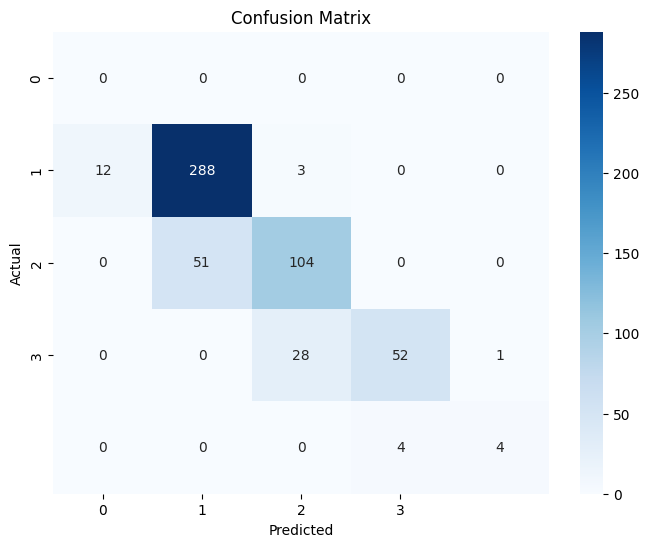

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and round them as before
preds, targs = learn.get_preds()
pred_class = preds.flatten().round().long()

# Convert to numpy arrays
targs_np = targs.flatten().numpy()
pred_class_np = pred_class.numpy()

# Calculate accuracy
accuracy = accuracy_score(targs_np, pred_class_np)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Create a confusion matrix
conf_matrix = confusion_matrix(targs_np, pred_class_np)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Submission File Preparation**

Finally, we prepare the submission by taking the predicted SII values for the test set, ensuring the format matches the Kaggle competition requirements, and saving it as a CSV file.

In [27]:
# Check if test_df has 20 rows
print(f"Number of rows in test.csv: {len(test_df)}")

# Slice the first 20 predictions from pred_class to match test.csv
pred_class_subset = pred_class[:len(test_df)]

# Create the submission DataFrame with 'id' from test.csv and the first 20 predictions
submission_df = pd.DataFrame({
    'id': test_df['id'],        # Use the 'id' column from test.csv
    'sii': pred_class_subset.numpy()  # Use the first 20 predictions
})

# Export the DataFrame to a CSV file without the index
submission_df.to_csv('submission.csv', index=False)


Number of rows in test.csv: 20
